In [1]:
import pylab as pl
import numpy as np
import scipy.stats as st

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

import data_loader
from modules import weight_init
from helpers import get_precision_recall

# Load data

In [36]:
PADDING_IDX = 0

train, test, _ = data_loader.read_dataset()
db = data_loader.InteractionsSampler(train.sequences, train.sequence_lengths, 
                                     template_size=40, query_size=10, min_nb_interactions=50, 
                                     num_negative=1000, perturb_prob=0.05)

db_test = data_loader.InteractionsSampler(test.sequences, test.sequence_lengths, 
                                          template_size=40, query_size=10, min_nb_interactions=50,
                                          num_negative=1000, perturb_prob=0.00)

train_loader = DataLoader(db, batch_size=128, num_workers=2)
test_loader = DataLoader(db_test, batch_size=1)


Loaded dataset of shape:(5058, 200)
Number of unique items: 3955
Loaded dataset of shape:(611, 200)
Number of unique items: 3955


# Define model

We train the model by creating a softmax of the dot product and computing the cross entropy loss.

    P(item|encoding) = exp(dot(encoding, item)) / SUM_i( exp(dot(encoding, item_i)) )


In [156]:
class SeqModel(nn.Module):
    """Container module with an encoder, deocder, embeddings."""

    def __init__(self, src_emb_dim, src_vocab_size, src_hidden_dim, trg_hidden_dim,
            pad_token_src=PADDING_IDX, nlayers=2, dropout=0.1):
        """Initialize model."""
        super(SeqModel, self).__init__()
        self.src_vocab_size = src_vocab_size
        self.src_emb_dim = src_emb_dim
        self.src_hidden_dim = src_hidden_dim
        self.trg_hidden_dim = trg_hidden_dim       
        self.nlayers = nlayers
        self.dropout = dropout
        self.pad_token_src = pad_token_src
        self.src_hidden_dim = src_hidden_dim

        self.src_embedding = nn.Embedding(src_vocab_size, src_emb_dim, padding_idx=self.pad_token_src)
        self.encoder = nn.GRU(
            src_emb_dim,
            self.src_hidden_dim,
            nlayers,
            batch_first=True,
            dropout=self.dropout
        )
        self.enc2emb = nn.Linear(trg_hidden_dim, src_emb_dim)
        self.init_weights()

    def init_weights(self):
        """Initialize weights."""
        self.src_embedding.weight.data.uniform_(0, 0.1)
        weight_init(self.enc2emb)

    def encode(self, input_src):
        """Propogate input through the encoder."""
        src_emb = self.src_embedding(input_src)
        src_h, _ = self.encoder(src_emb)
        return src_h
    
    def decode_one_step(self, state, input_trg_pos, input_trg_neg):
        """Will use the last hidden representation to predict the next step (1st element of input_trg_pos)"""
        
        trg_emb_pos = self.src_embedding(input_trg_pos)
        trg_emb_neg = Variable(self.src_embedding(input_trg_neg).data)
        batch_size = input_trg_pos.size(0)
        labels = Variable(torch.LongTensor(batch_size).fill_(0).cuda()).detach()
        nb_neg_samples = input_trg_neg.size(1)
        
        emb = self.enc2emb(state[:,-1])
        # create a concat of [Positive Sample; N negative samples]

        out = (emb.unsqueeze(1)).repeat(1, 1 + nb_neg_samples, 1)
        combo = torch.cat((trg_emb_pos[:,1].unsqueeze(1), trg_emb_neg), dim=1)

        pred = (combo*out).sum(2)
        pred = pred
        loss = F.cross_entropy(pred, labels)
        
        return out, loss, 0.0
    
    def decode_sequence(self, state, input_trg_pos, input_trg_neg):
        """Next stem prediction by creating softmax """
        batch_size = input_trg_pos.size(0)
        trg_emb_pos = self.src_embedding(input_trg_pos)
        trg_emb_neg = Variable(self.src_embedding(input_trg_neg).data) # stop gradients
        nb_neg_samples = input_trg_neg.size(1)

        labels = Variable(torch.LongTensor(batch_size).fill_(0).cuda()).detach()
        
        nb_steps = trg_emb_pos.size(1)
        out = self.enc2emb(state[:,:])
        total_loss = 0.0
        predictions = []
        for i in range(nb_steps):
            combo = torch.cat((trg_emb_pos[:,i].unsqueeze(1), trg_emb_neg), dim=1)
            step_out = (out[:,i].unsqueeze(1)).repeat(1, 1 + nb_neg_samples, 1)
            pred = (combo*step_out).sum(2)
            predictions.append(pred)
            total_loss+=F.cross_entropy(pred, labels)
        return predictions, total_loss
        
    def predict_one_step(self, state, test_items):
        """predict the next step by computing the dot product of the encoder state and the test_items"""
        nb_test_items = test_items.size(1)
        test_emb = self.src_embedding(test_items)
        outputs = []
        in_ = self.enc2emb(state[:,-1])
        out = (in_.unsqueeze(1)).repeat(1, nb_test_items, 1)
        pred = (test_emb*out).sum(2)
        return pred

In [157]:
model = SeqModel(32, db.num_items, 700, 700, 0, nlayers=1)
model.cuda()

SeqModel (
  (src_embedding): Embedding(3955, 32, padding_idx=0)
  (encoder): GRU(32, 700, batch_first=True, dropout=0.1)
  (enc2emb): Linear (700 -> 32)
)

In [158]:
parameters = model.parameters()
optimizer = torch.optim.Adam(
    parameters,
    weight_decay=0.0005,
    lr=0.0001
)


In [ ]:
model.train(True)
emb_0 = None
total_epochs = 100 
for e in range(total_epochs):
    total_loss = []
    for i, batch in enumerate(train_loader):
        basket, positive, negative, basket_len = batch
        basket_vb = Variable(basket.cuda())
        positive_vb = Variable(positive[:,1:-1].cuda())
        negative_vb = Variable(negative[:,1:-1].cuda())
        
        emb = model.encode(basket_vb[:,:-1])
        teacher = False
        if np.random.rand() < 0.2:
            teacher = True
        if i == 0:
            emb_0 = emb # save encoder state for debugging 
        pred, loss = model.decode_sequence(emb, basket_vb[:,1:], negative_vb)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 8.0)
        optimizer.step()
        total_loss.append(loss.data[0])
    if e % 5 ==0:
        print("epoch {} mean loss {}".format(e, np.mean(total_loss)))

epoch 0 mean loss 259.946183013916


Visualize the embedding. It helps detect diverging architectures.

(39, 700)


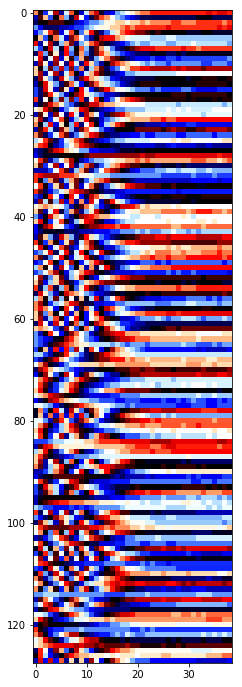

In [171]:
x = emb_0[52].data.cpu().numpy()
pl.figure(figsize=(10,12))
print(x.shape)
pl.imshow(x[:,:128].T, cmap='flag')


## Evaluate the test set. Report MRR and map@10

In [173]:

# switch to train mode
model.train(False)
item_ids = np.arange(db.num_items).reshape(1, -1)
item_ids = Variable(torch.from_numpy(item_ids.astype(np.int64)).cuda())
mrrs = []

prec = []
recall = []
item_emb = model.src_embedding(item_ids)
for i, (basket, positive, negative, labels) in enumerate(test_loader):
    basket_vb = Variable(basket.cuda())
    emb = model.encode(basket_vb)
#         positive = positive[:,1:-1].numpy()
    positive_vb = Variable(positive[:,0].cuda())

    out =  model.predict_one_step(emb, item_ids )
    out = -out.data.cpu().numpy().flatten()
    positive = positive.numpy()
    next_item = positive[0, 1:-1]
    # compute mrr
    mrr1 = (1.0 / st.rankdata(out)[next_item[0]]).mean()
    mrrs.append(mrr1)
    out = out.argsort()
    prec_, recall_ = get_precision_recall(out, next_item, 10)
    prec.append(prec_)
    recall.append(recall_)

print('Mrr:{}'.format(np.mean(mrrs)))
print('mean prec: {} , mean recall: {}'.format(np.mean(prec),
                                               np.mean(recall)))

Mrr:0.005430412072611628
mean prec: 0.008019639934533552 , mean recall: 0.008019639934533552
